# Preparing

In [2]:
# !nvidia-smi

## Install library

In [3]:
# !pip install --quiet pytorch-lightning==1.2.5
# !pip install --quiet tqdm==4.59.0

## Import libraries

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc, rcParams
import math

import pandas as pd
import numpy as np
import tqdm
print(tqdm.__version__)
from tqdm.notebook import tqdm
import pytorch_lightning as pl
print(pl.__version__)
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import autograd, nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

4.61.2
1.2.5


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALLETE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALLETE))

rcParams['figure.figsize'] = 12, 8

tqdm.pandas()

In [6]:
pl.seed_everything(42)

Global seed set to 42


42

# Data

In [7]:
Data_list = []
Column_names = []

### Load watch price

In [8]:
path = 'Datasets\Price_chart_Game\A. Lange & Söhne\A. Lange & Söhne 140.029\price.csv'
watch = pd.read_csv(path, index_col=0)
watch['Price'] = pd.to_numeric(watch['Price'])
watch.index = pd.to_datetime(watch.index, dayfirst=True)
watch = watch.resample('D', convention='s').mean()
watch.fillna(method='ffill', inplace=True)

Data_list.append(watch)
Column_names.append('watch_price')

watch.head()

,Price
Date,
2019-03-10,50931.0
2019-03-11,50931.0
2019-03-12,50931.0
2019-03-13,50931.0
2019-03-14,50931.0


### Load gold price

In [40]:
gold = pd.read_csv("Datasets\Gold_price.csv", index_col=0)
gold['Value'] = gold['Value'].str.replace(',','')
gold['Value'] = pd.to_numeric(gold['Value'])
gold.index = pd.to_datetime(gold.index, dayfirst=True)
gold = gold.resample('D', convention='s').mean()
gold.fillna(method='ffill', inplace=True)
print(gold.shape)

Data_list.append(gold)
Column_names.append('gold_price')

gold.head()

(1895, 1)


,Value
Date,
2017-01-02,1145.9
2017-01-03,1151.0
2017-01-04,1164.3
2017-01-05,1176.7
2017-01-06,1175.9


### Load Inflation rate

In [41]:
IR = pd.read_csv("Datasets\Inflation_rate.csv", index_col=0)
IR['Value'] = IR['Value'].str.replace(',','')
for _, item in IR.iterrows():
    if item[0] == '.': item[0] = np.nan
IR['Value'] = pd.to_numeric(IR['Value'])
IR.index = pd.to_datetime(IR.index, dayfirst=True)
IR = IR.resample('D', convention='s').mean()
IR.fillna(method='ffill', inplace=True)
print(IR.shape)
IR.head()

(1825, 1)


,Value
DATE,
2017-03-13,2.16
2017-03-14,2.10
2017-03-15,2.18
2017-03-16,2.17
2017-03-17,2.13


### Load stock data

In [42]:
GLG = pd.read_csv("Datasets\S&P Global Luxury Goods.csv", index_col=0)
for col in GLG.columns:
    GLG[col] = GLG[col].str.replace(',','')
    GLG[col] = GLG[col].str.replace('%','')
    GLG[col] = pd.to_numeric(GLG[col])
    Column_names.append('GLG_'+col)
GLG.index = pd.to_datetime(GLG.index, dayfirst=True)
GLG = GLG.resample('D', convention='s').mean()
GLG.fillna(method='ffill', inplace=True)
print(GLG.shape)
Data_list.append(GLG)
GLG.head()

(1795, 5)


,Price,Open,High,Low,Change %
Date,,,,,
2017-04-11,2138.81,2138.81,2138.81,2138.81,0.21
2017-04-12,2140.47,2140.47,2140.47,2140.47,0.08
2017-04-13,2137.98,2137.98,2137.98,2137.98,-0.12
2017-04-14,2137.31,2137.31,2137.31,2137.31,-0.03
2017-04-15,2137.31,2137.31,2137.31,2137.31,-0.03


## Concat all

In [43]:
df = pd.concat(Data_list, axis=1, join='inner')
df.columns = Column_names
print(df.shape)
df.head()

(1162, 7)


,watch_price,gold_price,GLG_Price,GLG_Open,GLG_High,GLG_Low,GLG_Change %
Date,,,,,,,
2019-01-04,50931.0,1279.9,2328.02,2328.02,2328.02,2328.02,3.19
2019-01-05,50931.0,1279.9,2328.02,2328.02,2328.02,2328.02,3.19
2019-01-06,50931.0,1279.9,2328.02,2328.02,2328.02,2328.02,3.19
2019-01-07,50931.0,1292.2,2353.99,2353.99,2353.99,2353.99,1.12
2019-01-08,50931.0,1286.5,2384.28,2384.28,2384.28,2384.28,1.29


In [55]:
df['Date'] = df.index
df.head()

,watch_price,gold_price,GLG_Price,GLG_Open,GLG_High,GLG_Low,GLG_Change %,Date
Date,,,,,,,,
2019-01-04,50931.0,1279.9,2328.02,2328.02,2328.02,2328.02,3.19,2019-01-04
2019-01-05,50931.0,1279.9,2328.02,2328.02,2328.02,2328.02,3.19,2019-01-05
2019-01-06,50931.0,1279.9,2328.02,2328.02,2328.02,2328.02,3.19,2019-01-06
2019-01-07,50931.0,1292.2,2353.99,2353.99,2353.99,2353.99,1.12,2019-01-07
2019-01-08,50931.0,1286.5,2384.28,2384.28,2384.28,2384.28,1.29,2019-01-08


In [44]:
# watch["Prev_Price"] = watch.shift(1)["Price"]
# watch.head()
# print(type(watch))

In [45]:
# watch["Price_Change"] = watch.progress_apply(
#     lambda row: 0 if np.isnan(row["Prev_Price"]) else row["Price"] - row["Prev_Price"],
#     axis = 1
# )
# watch.head()

## Loading other data

In [46]:
# gold = pd.read_csv("Datasets\Gold_price.csv")
# gold['Value'] = gold['Value'].str.replace(',','')
# gold['Date'] = pd.to_datetime(gold['Date'], dayfirst=True)
# gold['Value'] = pd.to_numeric(gold['Value'])
# mask = (gold.Date >= watch.iloc[0]['Date']) & (gold.Date <= watch.iloc[-1]['Date'])
# gold = gold.loc[mask]

# gold = gold.resample('D', on='Date', convention='s').mean()
# gold.fillna(method='ffill', inplace=True)

# print(gold.shape)
# gold.head()

In [47]:
# IR = pd.read_csv("Datasets\Inflation_rate.csv")
# IR['Value'] = IR['Value'].str.replace(',','')
# IR['Date'] = pd.to_datetime(IR['Date'], dayfirst=True)
# IR['Value'] = pd.to_numeric(IR['Value'])
# IR = (IR.Date >= watch.iloc[0]['Date']) & (IR.Date <= watch.iloc[-1]['Date'])
# IR = IR.loc[mask]

# IR = IR.resample('D', on='Date', convention='s').mean()
# IR.fillna(method='ffill', inplace=True)

# print(IR.shape)
# IR.head()

## Create feature df

In [56]:
rows = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_data = dict(
        day_of_week = row.Date.dayofweek,
        day_of_month = row.Date.day,
        week_of_year = row.Date.week,
        month = row.Date.month,
        watch_price = row.watch_price,
        gold_price = row.gold_price,
        GLG_Price = row.GLG_Price,
        GLG_Open = row.GLG_Open,
        GLG_High = row.GLG_High,
        GLG_Low = row.GLG_Low,
        GLG_Change = row['GLG_Change %']
        
    )
    rows.append(row_data)

features_df = pd.DataFrame(rows)

  0%|          | 0/1162 [00:00<?, ?it/s]

In [57]:
# print(features_df.shape)
# features_df.head()

## Set TRAIN_RATIO

In [58]:
TRAIN_RATIO = 0.6

train_size = int(len(features_df) * TRAIN_RATIO)
print(train_size)

697


In [59]:
train_df, test_df = features_df[:train_size], features_df[train_size:]
print(train_df.shape, test_df.shape)

(697, 11) (465, 11)


In [60]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_df)

In [61]:
train_df = pd.DataFrame(
    scaler.transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

In [62]:
test_df = pd.DataFrame(
    scaler.transform(test_df),
    index=test_df.index,
    columns=test_df.columns
)

In [63]:
test_df.head()

,day_of_week,day_of_month,week_of_year,month,watch_price,gold_price,GLG_Price,GLG_Open,GLG_High,GLG_Low,GLG_Change
697,-0.666667,-1.000000,0.882353,1.0,-1.0,0.357152,1.009622,1.009622,1.009622,1.009622,0.153846
698,-0.333333,-0.933333,0.882353,1.0,-1.0,0.386737,1.011749,1.011749,1.011749,1.011749,0.022727
699,0.000000,-0.866667,0.882353,1.0,-1.0,0.411308,1.066426,1.066426,1.066426,1.066426,0.145105
700,0.333333,-0.800000,0.882353,1.0,-1.0,0.437884,1.081614,1.081614,1.081614,1.081614,0.052448
701,0.666667,-0.733333,0.882353,1.0,-1.0,0.437884,1.081614,1.081614,1.081614,1.081614,0.052448


In [64]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length, days_pred):

    sequences = []
    data_size = len(input_data)

    for i in tqdm(range(data_size - sequence_length - days_pred)):

        sequence = input_data[i:i+sequence_length]

        label_position = i + sequence_length + days_pred
        label = input_data.iloc[label_position][target_column]
        
        sequences.append((sequence, label))

    return sequences

## Set SEQUENCE_LENGTH and Created sequences

In [66]:
SEQUENCE_LENGTH = 30
DAYS_PREDICTION = 30

train_sequences = create_sequences(train_df, "watch_price", SEQUENCE_LENGTH, DAYS_PREDICTION)
test_sequences = create_sequences(test_df, "watch_price", SEQUENCE_LENGTH, DAYS_PREDICTION)

  0%|          | 0/637 [00:00<?, ?it/s]

  0%|          | 0/405 [00:00<?, ?it/s]

In [67]:
print(f"Sequence shape: {train_sequences[0][0].shape}")
print(f"Train length: {len(train_sequences)}")
print(f"Test length: {len(test_sequences)}")
print(f"Test length: {train_sequences[0][1]}")
train_sequences[0][0].head()

Sequence shape: (30, 11)
Train length: 637
Test length: 405
Test length: -0.2634979233964021


,day_of_week,day_of_month,week_of_year,month,watch_price,gold_price,GLG_Price,GLG_Open,GLG_High,GLG_Low,GLG_Change
0,0.333333,-0.800000,-1.000000,-1.0,-0.263498,-0.973925,-0.463622,-0.463622,-0.463622,-0.463622,0.296329
1,0.666667,-0.733333,-1.000000,-1.0,-0.263498,-0.973925,-0.463622,-0.463622,-0.463622,-0.463622,0.296329
2,1.000000,-0.666667,-1.000000,-1.0,-0.263498,-0.973925,-0.463622,-0.463622,-0.463622,-0.463622,0.296329
3,-1.000000,-0.600000,-0.960784,-1.0,-0.263498,-0.943086,-0.438174,-0.438174,-0.438174,-0.438174,0.115385
4,-0.666667,-0.533333,-0.960784,-1.0,-0.263498,-0.957377,-0.408494,-0.408494,-0.408494,-0.408494,0.130245


# Classes create

## Set device

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print("configured device:", device)

configured device: cuda


## TS_Dataset (Time series)

In [69]:
class TS_Dataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()).to(device),
            label = torch.tensor(label).float().to(device)
        )

## Price Data Module

In [70]:
class PriceDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size=8):
        super().__init__
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def prepare_data(self):
        self._has_prepared_data = True

    def setup(self):
        self.train_dataset = TS_Dataset(self.train_sequences)
        self.test_dataset = TS_Dataset(self.test_sequences)
        self.prepare_data()
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=4,
            shuffle=False
        )
        
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False
        )

## Define BATCH_SIZE and N_EPOCHS

In [71]:
N_EPOCHS = 20
BATCH_SIZE = 128

data_module = PriceDataModule(train_sequences, test_sequences, batch_size=BATCH_SIZE)
data_module.setup()

In [72]:
train_dataset = TS_Dataset(train_sequences)

In [73]:
for item in train_dataset:
    print(item["sequence"].shape)
    print(item["label"].shape)
    print(item["label"])
    break

torch.Size([30, 11])
torch.Size([])
tensor(-0.2635, device='cuda:0')


## Price Prediction Model

In [74]:
class PricePredictionModel(nn.Module):

    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()
        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size =n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = 0.2
        )
        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

## Price Predictor

In [75]:
class PricePredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()
        self.model = PricePredictionModel(n_features).to(device)
        self.criterion = nn.MSELoss().to(device)

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss    

    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.Adagrad(self.parameters(), lr=1e-3)

In [76]:
model = PricePredictor(n_features=train_df.shape[1])

In [77]:
for item in data_module.train_dataloader():
    print(item["sequence"].shape)
    print(item["label"].shape)
    break

torch.Size([128, 30, 11])
torch.Size([128])


# Start Tensorboard

In [78]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

## checkpoint_callback setup

In [79]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    # verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="watch-price")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

C:\Users\THETANG\anaconda3\envs\BIA_env\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


## Fit

In [82]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 204 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
204 K     Trainable params
0         Non-trainable params
204 K     Total params
0.818     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 107/107 [00:00<00:00, 218.37it/s, loss=0.34, v_num=2, val_loss=12.40, train_loss=0.435] 


1

# Evaluation

## Load trained model

In [83]:
trained_model = PricePredictor.load_from_checkpoint(
    "checkpoints/best-checkpoint-v2.ckpt",
    n_features=train_df.shape[1]
)

In [84]:
trained_model.freeze()

## Predictions

In [85]:
test_dataset = TS_Dataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item['sequence']
    label = item['label']

    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

  0%|          | 0/405 [00:00<?, ?it/s]

In [86]:
len(predictions), len(test_df)-SEQUENCE_LENGTH

(405, 435)

## Descale

In [87]:
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [88]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

print("Predictions: ", predictions_descaled[:5])
print("Labels: ", labels_descaled[:5])

Predictions:  [-2.0168751  -2.0177837  -2.051255   -2.08463101 -2.06563306]
Labels:  [6.00304585 7.30876488 7.30876488 7.30876488 7.30876488]


## Plot graph

In [89]:
# train_data = watch[:train_size]
test_data = watch[train_size:]
print(test_data.shape)
print(test_df.shape)

(732, 1)
(465, 11)


In [90]:
test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]
print(test_sequences_data.shape)

(702, 1)


In [92]:
test_sequences_data.head()

,Price
Date,
2020-12-31,52686.0
2021-01-01,52686.0
2021-01-02,52686.0
2021-01-03,55996.0
2021-01-04,58305.0


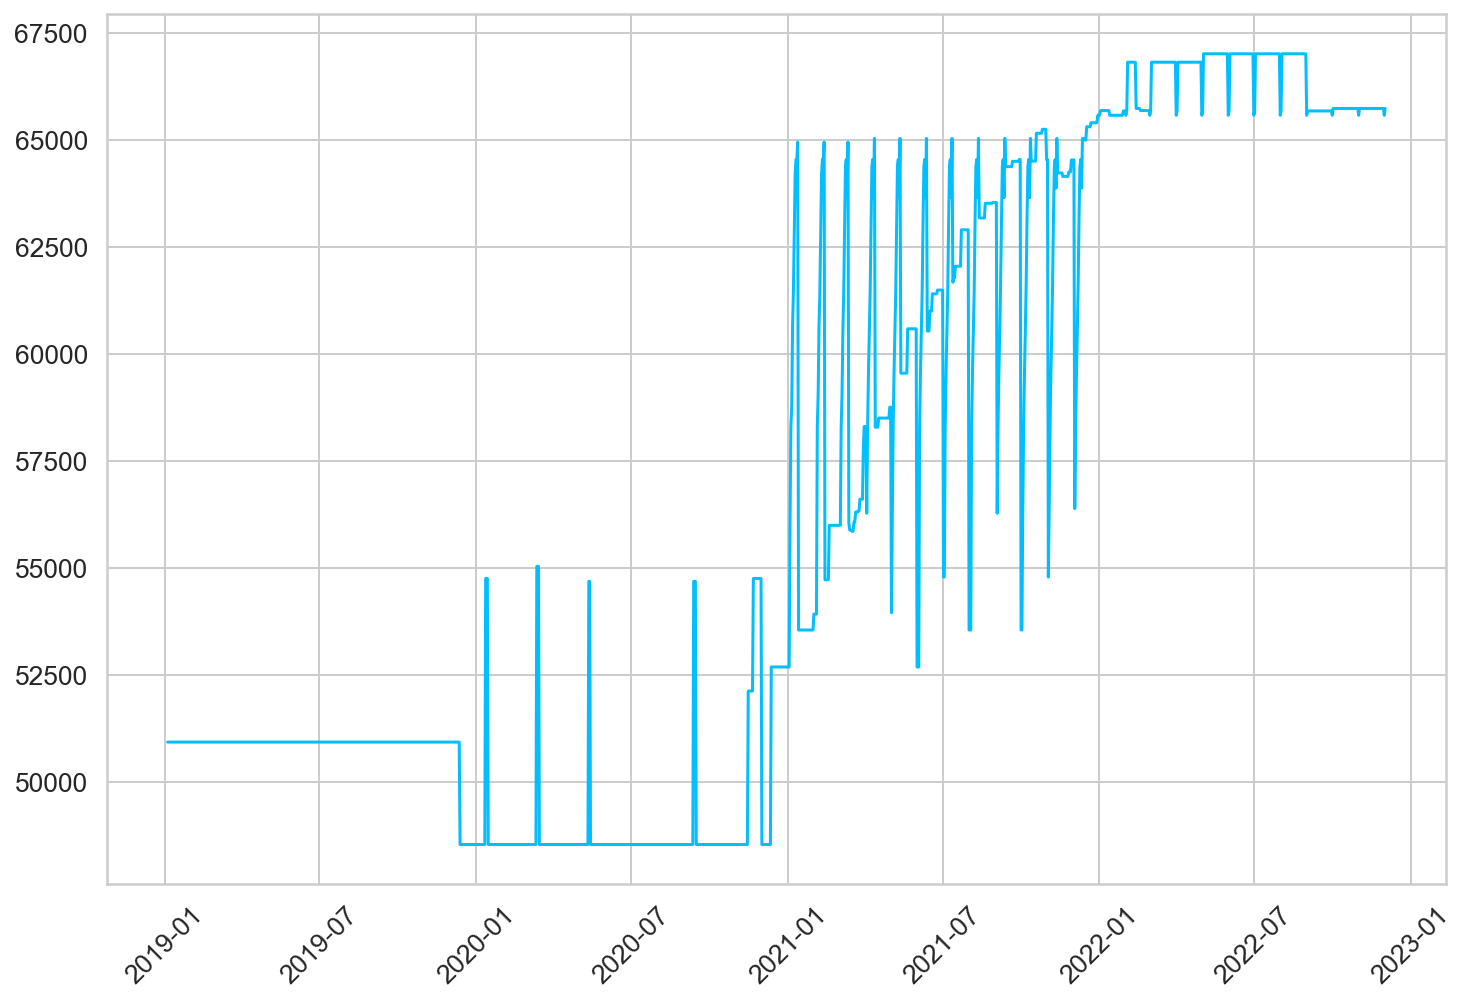

In [94]:
test_dates = matplotlib.dates.date2num(test_sequences_data.index.tolist())
all_dates = matplotlib.dates.date2num(watch.index.tolist())
# plt.plot_date(test_dates[DAYS_PREDICTION:], predictions_descaled, '-', label='predicted')
# plt.plot_date(test_dates, labels_descaled, '-', label='real')
plt.plot_date(all_dates, watch.Price.tolist(), '-', label='real')
i = 150
# plt.plot_date([test_dates[i], test_dates[DAYS_PREDICTION+i]], [labels_descaled[i-DAYS_PREDICTION], predictions_descaled[i]], '-', label='PREDICTION')

plt.xticks(rotation=45)
# plt.legend()
plt.show()

# Evalution function

In [ ]:
# class prediction:
#     def __init__(self, model_path, n_features):
#         self.trained_model = PricePredictor.load_from_checkpoint(
#             model_path,
#             n_features=n_features
#         )
#         self.trained_model.freeze()

#     def get_result(self, sequence, days):
#         _, predictions = trained_model(sequence.unsqueeze(dim=0))
        
